1/1 [==============================] - 0s 49ms/step

Computation calculations for Fold 1:
Execution Time: 11.43 seconds
CPU Usage: 28.3%
Memory Used: 15545.40 MB
1/1 [==============================] - 0s 51ms/step

Computation calculations for Fold 2:
Execution Time: 9.86 seconds
CPU Usage: 26.7%
Memory Used: 15605.68 MB
1/1 [==============================] - 0s 37ms/step

Computation calculations for Fold 3:
Execution Time: 10.49 seconds
CPU Usage: 28.0%
Memory Used: 15639.97 MB
1/1 [==============================] - 0s 46ms/step

Computation calculations for Fold 4:
Execution Time: 10.16 seconds
CPU Usage: 23.3%
Memory Used: 15661.50 MB
1/1 [==============================] - 0s 31ms/step

Computation calculations for Fold 5:
Execution Time: 10.18 seconds
CPU Usage: 22.6%
Memory Used: 15752.10 MB

Best Fold: 3
Best Train RMSE: 11.54695
Best Validation RMSE: 5.06574
Best Train MAE: 9.72880
Best Validation MAE: 4.86605
Best Train R2: 0.08557
Best Validation R2: -0.42565


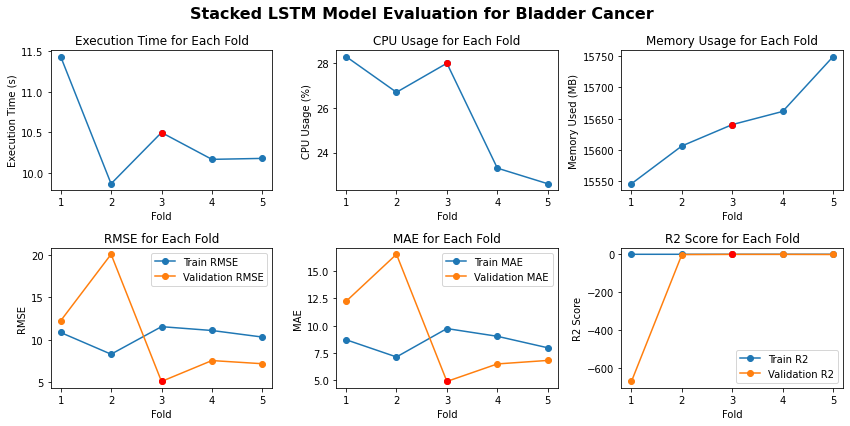

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load and preprocess the cancer dataset
data = pd.DataFrame({
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'Bladder': [23, 19, 19, 18, 29, 43, 62, 30, 29, 34, 25, 25, 22, 29, 40, 25, 41, 41, 29, 37, 13],
    'Brain': [24, 26, 28, 26, 40, 44, 68, 42, 31, 29, 35, 36, 30, 31, 31, 32, 13, 16, 24, 14, 9],
    'Breast': [68, 90, 86, 53, 91, 103, 133, 124, 114, 97, 157, 144, 143, 150, 244, 179, 219, 190, 130, 199, 133],
    'Bronchus_Lung': [37, 35, 36, 31, 74, 101, 101, 79, 89, 75, 61, 36, 63, 71, 99, 56, 15, 35, 9, 37, 39],
    'Colorectal': [22, 22, 24, 10, 36, 31, 42, 24, 37, 36, 47, 49, 53, 49, 70, 57, 24, 39, 35, 46, 21],
    'Leukemia': [20, 20, 25, 23, 33, 39, 63, 52, 48, 32, 59, 46, 53, 35, 53, 47, 33, 55, 38, 41, 46],
    'Non_Hodgkins_Lymphoma': [47, 18, 27, 18, 31, 33, 35, 18, 31, 23, 48, 39, 37, 28, 49, 31, 34, 34, 3, 22, 30],
    'Stomach': [18, 18, 21, 25, 25, 34, 34, 27, 33, 40, 20, 31, 26, 39, 37, 27, 20, 21, 11, 12, 12]
})

# Select a cancer type column as the target variable
cancer_type = 'Bladder'  # Change to the desired cancer type

target = data[cancer_type].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Define number of folds
num_folds = 5

# Compute fold size
fold_size = len(target_scaled) // num_folds

# Initialize lists to store evaluation metrics and computation calculations for each fold
eval_metrics = []
execution_times = []
cpu_usages = []
memory_usages = []

# Initialize variables for best fold and metric
best_fold = 0
best_metric = float('inf')

# Perform k-fold cross-validation
for fold in range(1, num_folds + 1):
    # Define the training and validation data for the current fold
    start_index = (fold - 1) * fold_size
    end_index = fold * fold_size
    val_data = target_scaled[start_index:end_index]
    train_data = np.concatenate((target_scaled[:start_index], target_scaled[end_index:]))

    def train_evaluate_model(train_data, val_data):
        X_train, y_train = train_data[:-1], train_data[1:]
        X_val, y_val = val_data[:-1], val_data[1:]

        # Define and train the Stacked LSTM model
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(1, 1)))
        model.add(LSTM(64))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # Make predictions
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)

        # Invert the scaling
        train_predictions = scaler.inverse_transform(train_predictions)
        y_train = scaler.inverse_transform(y_train)
        val_predictions = scaler.inverse_transform(val_predictions)
        y_val = scaler.inverse_transform(y_val)

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        train_r2 = r2_score(y_train, train_predictions)
        val_r2 = r2_score(y_val, val_predictions)

        # Store evaluation metrics for the current fold
        eval_metrics.append((train_rmse, val_rmse, train_mae, val_mae, train_r2, val_r2))

        return train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions

    # Train and evaluate the Stacked LSTM model
    start_time = time.time()
    train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions = train_evaluate_model(train_data, val_data)
    computation_time = time.time() - start_time

    # Measure CPU usage during model training
    cpu_usage = psutil.cpu_percent()

    # Record computation calculations
    execution_times.append(computation_time)
    cpu_usages.append(cpu_usage)
    memory_usages.append(psutil.virtual_memory().used / 1024 / 1024)  # Memory usage in MB

    # Check if the current fold has the best metric
    if val_rmse < best_metric:
        best_metric = val_rmse
        best_fold = fold

    # Print computation calculations for the current fold
    print(f"\nComputation calculations for Fold {fold}:")
    print(f"Execution Time: {computation_time:.2f} seconds")
    print(f"CPU Usage: {cpu_usage}%")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024:.2f} MB")

# Print the evaluation metrics for the best fold
best_train_rmse, best_val_rmse, best_train_mae, best_val_mae, best_train_r2, best_val_r2 = eval_metrics[best_fold - 1]
print(f"\nBest Fold: {best_fold}")
print(f"Best Train RMSE: {best_train_rmse:.5f}")
print(f"Best Validation RMSE: {best_val_rmse:.5f}")
print(f"Best Train MAE: {best_train_mae:.5f}")
print(f"Best Validation MAE: {best_val_mae:.5f}")
print(f"Best Train R2: {best_train_r2:.5f}")
print(f"Best Validation R2: {best_val_r2:.5f}")

# Plot computation calculations for each fold
plt.figure(figsize=(12, 6))
plt.suptitle(f'Stacked LSTM Model Evaluation for {cancer_type} Cancer', fontsize=16, fontweight='bold')

plt.subplot(231)
plt.plot(range(1, num_folds + 1), execution_times, 'o-')
plt.plot(best_fold, execution_times[best_fold - 1], 'ro')
plt.title('Execution Time for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Execution Time (s)')

plt.subplot(232)
plt.plot(range(1, num_folds + 1), cpu_usages, 'o-')
plt.plot(best_fold, cpu_usages[best_fold - 1], 'ro')
plt.title('CPU Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('CPU Usage (%)')

plt.subplot(233)
plt.plot(range(1, num_folds + 1), memory_usages, 'o-')
plt.plot(best_fold, memory_usages[best_fold - 1], 'ro')
plt.title('Memory Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Memory Used (MB)')

# Plot evaluation metrics for each fold
plt.subplot(234)
train_rmses = [metrics[0] for metrics in eval_metrics]
val_rmses = [metrics[1] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_rmses, 'o-', label='Train RMSE')
plt.plot(range(1, num_folds + 1), val_rmses, 'o-', label='Validation RMSE')
plt.plot(best_fold, best_val_rmse, 'ro')
plt.title('RMSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(235)
train_maes = [metrics[2] for metrics in eval_metrics]
val_maes = [metrics[3] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_maes, 'o-', label='Train MAE')
plt.plot(range(1, num_folds + 1), val_maes, 'o-', label='Validation MAE')
plt.plot(best_fold, best_val_mae, 'ro')
plt.title('MAE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend()

plt.subplot(236)
train_r2_scores = [metrics[4] for metrics in eval_metrics]
val_r2_scores = [metrics[5] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_r2_scores, 'o-', label='Train R2')
plt.plot(range(1, num_folds + 1), val_r2_scores, 'o-', label='Validation R2')
plt.plot(best_fold, best_val_r2, 'ro')
plt.title('R2 Score for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 43ms/step

Computation calculations for Fold 1:
Execution Time: 10.68 seconds
CPU Usage: 28.2%
Memory Used: 15730.02 MB
1/1 [==============================] - 0s 43ms/step

Computation calculations for Fold 2:
Execution Time: 10.99 seconds
CPU Usage: 30.4%
Memory Used: 15717.98 MB
1/1 [==============================] - 0s 48ms/step

Computation calculations for Fold 3:
Execution Time: 10.44 seconds
CPU Usage: 27.1%
Memory Used: 15753.38 MB
1/1 [==============================] - 0s 33ms/step

Computation calculations for Fold 4:
Execution Time: 10.94 seconds
CPU Usage: 24.2%
Memory Used: 15702.50 MB
1/1 [==============================] - 0s 43ms/step

Computation calculations for Fold 5:
Execution Time: 10.31 seconds
CPU Usage: 23.0%
Memory Used: 15750.69 MB

Best Fold: 4
Best Train RMSE: 11.92231
Best Validation RMSE: 1.31254
Best Train MAE: 8.54473
Best Validation MAE: 1.24579
Best Train R2: 0.28950
Best Validation R2: -6.75245


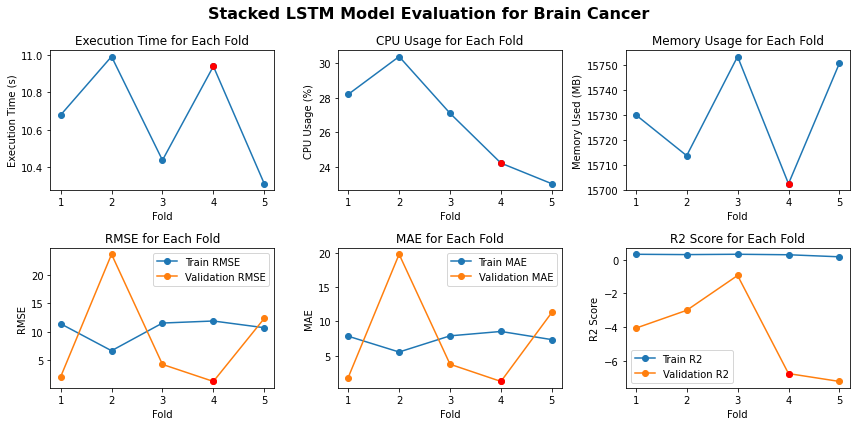

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load and preprocess the cancer dataset
data = pd.DataFrame({
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'Bladder': [23, 19, 19, 18, 29, 43, 62, 30, 29, 34, 25, 25, 22, 29, 40, 25, 41, 41, 29, 37, 13],
    'Brain': [24, 26, 28, 26, 40, 44, 68, 42, 31, 29, 35, 36, 30, 31, 31, 32, 13, 16, 24, 14, 9],
    'Breast': [68, 90, 86, 53, 91, 103, 133, 124, 114, 97, 157, 144, 143, 150, 244, 179, 219, 190, 130, 199, 133],
    'Bronchus_Lung': [37, 35, 36, 31, 74, 101, 101, 79, 89, 75, 61, 36, 63, 71, 99, 56, 15, 35, 9, 37, 39],
    'Colorectal': [22, 22, 24, 10, 36, 31, 42, 24, 37, 36, 47, 49, 53, 49, 70, 57, 24, 39, 35, 46, 21],
    'Leukemia': [20, 20, 25, 23, 33, 39, 63, 52, 48, 32, 59, 46, 53, 35, 53, 47, 33, 55, 38, 41, 46],
    'Non_Hodgkins_Lymphoma': [47, 18, 27, 18, 31, 33, 35, 18, 31, 23, 48, 39, 37, 28, 49, 31, 34, 34, 3, 22, 30],
    'Stomach': [18, 18, 21, 25, 25, 34, 34, 27, 33, 40, 20, 31, 26, 39, 37, 27, 20, 21, 11, 12, 12]
})

# Select a cancer type column as the target variable
cancer_type = 'Brain'  # Change to the desired cancer type

target = data[cancer_type].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Define number of folds
num_folds = 5

# Compute fold size
fold_size = len(target_scaled) // num_folds

# Initialize lists to store evaluation metrics and computation calculations for each fold
eval_metrics = []
execution_times = []
cpu_usages = []
memory_usages = []

# Initialize variables for best fold and metric
best_fold = 0
best_metric = float('inf')

# Perform k-fold cross-validation
for fold in range(1, num_folds + 1):
    # Define the training and validation data for the current fold
    start_index = (fold - 1) * fold_size
    end_index = fold * fold_size
    val_data = target_scaled[start_index:end_index]
    train_data = np.concatenate((target_scaled[:start_index], target_scaled[end_index:]))

    def train_evaluate_model(train_data, val_data):
        X_train, y_train = train_data[:-1], train_data[1:]
        X_val, y_val = val_data[:-1], val_data[1:]

        # Define and train the Stacked LSTM model
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(1, 1)))
        model.add(LSTM(64))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # Make predictions
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)

        # Invert the scaling
        train_predictions = scaler.inverse_transform(train_predictions)
        y_train = scaler.inverse_transform(y_train)
        val_predictions = scaler.inverse_transform(val_predictions)
        y_val = scaler.inverse_transform(y_val)

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        train_r2 = r2_score(y_train, train_predictions)
        val_r2 = r2_score(y_val, val_predictions)

        # Store evaluation metrics for the current fold
        eval_metrics.append((train_rmse, val_rmse, train_mae, val_mae, train_r2, val_r2))

        return train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions

    # Train and evaluate the Stacked LSTM model
    start_time = time.time()
    train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions = train_evaluate_model(train_data, val_data)
    computation_time = time.time() - start_time

    # Measure CPU usage during model training
    cpu_usage = psutil.cpu_percent()

    # Record computation calculations
    execution_times.append(computation_time)
    cpu_usages.append(cpu_usage)
    memory_usages.append(psutil.virtual_memory().used / 1024 / 1024)  # Memory usage in MB

    # Check if the current fold has the best metric
    if val_rmse < best_metric:
        best_metric = val_rmse
        best_fold = fold

    # Print computation calculations for the current fold
    print(f"\nComputation calculations for Fold {fold}:")
    print(f"Execution Time: {computation_time:.2f} seconds")
    print(f"CPU Usage: {cpu_usage}%")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024:.2f} MB")

# Print the evaluation metrics for the best fold
best_train_rmse, best_val_rmse, best_train_mae, best_val_mae, best_train_r2, best_val_r2 = eval_metrics[best_fold - 1]
print(f"\nBest Fold: {best_fold}")
print(f"Best Train RMSE: {best_train_rmse:.5f}")
print(f"Best Validation RMSE: {best_val_rmse:.5f}")
print(f"Best Train MAE: {best_train_mae:.5f}")
print(f"Best Validation MAE: {best_val_mae:.5f}")
print(f"Best Train R2: {best_train_r2:.5f}")
print(f"Best Validation R2: {best_val_r2:.5f}")

# Plot computation calculations for each fold
plt.figure(figsize=(12, 6))
plt.suptitle(f'Stacked LSTM Model Evaluation for {cancer_type} Cancer', fontsize=16, fontweight='bold')

plt.subplot(231)
plt.plot(range(1, num_folds + 1), execution_times, 'o-')
plt.plot(best_fold, execution_times[best_fold - 1], 'ro')
plt.title('Execution Time for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Execution Time (s)')

plt.subplot(232)
plt.plot(range(1, num_folds + 1), cpu_usages, 'o-')
plt.plot(best_fold, cpu_usages[best_fold - 1], 'ro')
plt.title('CPU Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('CPU Usage (%)')

plt.subplot(233)
plt.plot(range(1, num_folds + 1), memory_usages, 'o-')
plt.plot(best_fold, memory_usages[best_fold - 1], 'ro')
plt.title('Memory Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Memory Used (MB)')

# Plot evaluation metrics for each fold
plt.subplot(234)
train_rmses = [metrics[0] for metrics in eval_metrics]
val_rmses = [metrics[1] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_rmses, 'o-', label='Train RMSE')
plt.plot(range(1, num_folds + 1), val_rmses, 'o-', label='Validation RMSE')
plt.plot(best_fold, best_val_rmse, 'ro')
plt.title('RMSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(235)
train_maes = [metrics[2] for metrics in eval_metrics]
val_maes = [metrics[3] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_maes, 'o-', label='Train MAE')
plt.plot(range(1, num_folds + 1), val_maes, 'o-', label='Validation MAE')
plt.plot(best_fold, best_val_mae, 'ro')
plt.title('MAE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend()

plt.subplot(236)
train_r2_scores = [metrics[4] for metrics in eval_metrics]
val_r2_scores = [metrics[5] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_r2_scores, 'o-', label='Train R2')
plt.plot(range(1, num_folds + 1), val_r2_scores, 'o-', label='Validation R2')
plt.plot(best_fold, best_val_r2, 'ro')
plt.title('R2 Score for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 40ms/step

Computation calculations for Fold 1:
Execution Time: 11.03 seconds
CPU Usage: 24.7%
Memory Used: 15582.93 MB
1/1 [==============================] - 0s 37ms/step

Computation calculations for Fold 2:
Execution Time: 10.34 seconds
CPU Usage: 26.3%
Memory Used: 15627.39 MB
1/1 [==============================] - 0s 38ms/step

Computation calculations for Fold 3:
Execution Time: 10.75 seconds
CPU Usage: 24.8%
Memory Used: 15615.01 MB
1/1 [==============================] - 0s 38ms/step

Computation calculations for Fold 4:
Execution Time: 10.23 seconds
CPU Usage: 24.8%
Memory Used: 15650.40 MB
1/1 [==============================] - 0s 31ms/step

Computation calculations for Fold 5:
Execution Time: 10.98 seconds
CPU Usage: 25.8%
Memory Used: 15633.00 MB

Best Fold: 2
Best Train RMSE: 43.16245
Best Validation RMSE: 21.45294
Best Train MAE: 34.56245
Best Validation MAE: 18.34643
Best Train R2: 0.25755
Best Validation R2: -1.91284


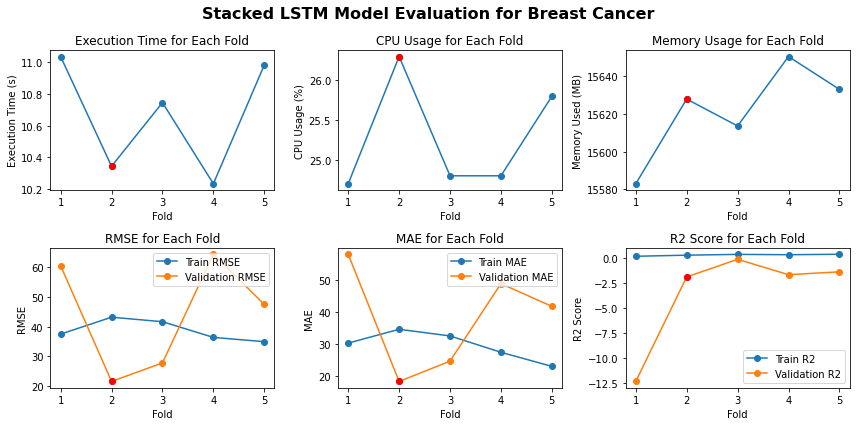

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load and preprocess the cancer dataset
data = pd.DataFrame({
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'Bladder': [23, 19, 19, 18, 29, 43, 62, 30, 29, 34, 25, 25, 22, 29, 40, 25, 41, 41, 29, 37, 13],
    'Brain': [24, 26, 28, 26, 40, 44, 68, 42, 31, 29, 35, 36, 30, 31, 31, 32, 13, 16, 24, 14, 9],
    'Breast': [68, 90, 86, 53, 91, 103, 133, 124, 114, 97, 157, 144, 143, 150, 244, 179, 219, 190, 130, 199, 133],
    'Bronchus_Lung': [37, 35, 36, 31, 74, 101, 101, 79, 89, 75, 61, 36, 63, 71, 99, 56, 15, 35, 9, 37, 39],
    'Colorectal': [22, 22, 24, 10, 36, 31, 42, 24, 37, 36, 47, 49, 53, 49, 70, 57, 24, 39, 35, 46, 21],
    'Leukemia': [20, 20, 25, 23, 33, 39, 63, 52, 48, 32, 59, 46, 53, 35, 53, 47, 33, 55, 38, 41, 46],
    'Non_Hodgkins_Lymphoma': [47, 18, 27, 18, 31, 33, 35, 18, 31, 23, 48, 39, 37, 28, 49, 31, 34, 34, 3, 22, 30],
    'Stomach': [18, 18, 21, 25, 25, 34, 34, 27, 33, 40, 20, 31, 26, 39, 37, 27, 20, 21, 11, 12, 12]
})

# Select a cancer type column as the target variable
cancer_type = 'Breast'  # Change to the desired cancer type

target = data[cancer_type].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Define number of folds
num_folds = 5

# Compute fold size
fold_size = len(target_scaled) // num_folds

# Initialize lists to store evaluation metrics and computation calculations for each fold
eval_metrics = []
execution_times = []
cpu_usages = []
memory_usages = []

# Initialize variables for best fold and metric
best_fold = 0
best_metric = float('inf')

# Perform k-fold cross-validation
for fold in range(1, num_folds + 1):
    # Define the training and validation data for the current fold
    start_index = (fold - 1) * fold_size
    end_index = fold * fold_size
    val_data = target_scaled[start_index:end_index]
    train_data = np.concatenate((target_scaled[:start_index], target_scaled[end_index:]))

    def train_evaluate_model(train_data, val_data):
        X_train, y_train = train_data[:-1], train_data[1:]
        X_val, y_val = val_data[:-1], val_data[1:]

        # Define and train the Stacked LSTM model
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(1, 1)))
        model.add(LSTM(64))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # Make predictions
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)

        # Invert the scaling
        train_predictions = scaler.inverse_transform(train_predictions)
        y_train = scaler.inverse_transform(y_train)
        val_predictions = scaler.inverse_transform(val_predictions)
        y_val = scaler.inverse_transform(y_val)

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        train_r2 = r2_score(y_train, train_predictions)
        val_r2 = r2_score(y_val, val_predictions)

        # Store evaluation metrics for the current fold
        eval_metrics.append((train_rmse, val_rmse, train_mae, val_mae, train_r2, val_r2))

        return train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions

    # Train and evaluate the Stacked LSTM model
    start_time = time.time()
    train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions = train_evaluate_model(train_data, val_data)
    computation_time = time.time() - start_time

    # Measure CPU usage during model training
    cpu_usage = psutil.cpu_percent()

    # Record computation calculations
    execution_times.append(computation_time)
    cpu_usages.append(cpu_usage)
    memory_usages.append(psutil.virtual_memory().used / 1024 / 1024)  # Memory usage in MB

    # Check if the current fold has the best metric
    if val_rmse < best_metric:
        best_metric = val_rmse
        best_fold = fold

    # Print computation calculations for the current fold
    print(f"\nComputation calculations for Fold {fold}:")
    print(f"Execution Time: {computation_time:.2f} seconds")
    print(f"CPU Usage: {cpu_usage}%")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024:.2f} MB")

# Print the evaluation metrics for the best fold
best_train_rmse, best_val_rmse, best_train_mae, best_val_mae, best_train_r2, best_val_r2 = eval_metrics[best_fold - 1]
print(f"\nBest Fold: {best_fold}")
print(f"Best Train RMSE: {best_train_rmse:.5f}")
print(f"Best Validation RMSE: {best_val_rmse:.5f}")
print(f"Best Train MAE: {best_train_mae:.5f}")
print(f"Best Validation MAE: {best_val_mae:.5f}")
print(f"Best Train R2: {best_train_r2:.5f}")
print(f"Best Validation R2: {best_val_r2:.5f}")

# Plot computation calculations for each fold
plt.figure(figsize=(12, 6))
plt.suptitle(f'Stacked LSTM Model Evaluation for {cancer_type} Cancer', fontsize=16, fontweight='bold')

plt.subplot(231)
plt.plot(range(1, num_folds + 1), execution_times, 'o-')
plt.plot(best_fold, execution_times[best_fold - 1], 'ro')
plt.title('Execution Time for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Execution Time (s)')

plt.subplot(232)
plt.plot(range(1, num_folds + 1), cpu_usages, 'o-')
plt.plot(best_fold, cpu_usages[best_fold - 1], 'ro')
plt.title('CPU Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('CPU Usage (%)')

plt.subplot(233)
plt.plot(range(1, num_folds + 1), memory_usages, 'o-')
plt.plot(best_fold, memory_usages[best_fold - 1], 'ro')
plt.title('Memory Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Memory Used (MB)')

# Plot evaluation metrics for each fold
plt.subplot(234)
train_rmses = [metrics[0] for metrics in eval_metrics]
val_rmses = [metrics[1] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_rmses, 'o-', label='Train RMSE')
plt.plot(range(1, num_folds + 1), val_rmses, 'o-', label='Validation RMSE')
plt.plot(best_fold, best_val_rmse, 'ro')
plt.title('RMSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(235)
train_maes = [metrics[2] for metrics in eval_metrics]
val_maes = [metrics[3] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_maes, 'o-', label='Train MAE')
plt.plot(range(1, num_folds + 1), val_maes, 'o-', label='Validation MAE')
plt.plot(best_fold, best_val_mae, 'ro')
plt.title('MAE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend()

plt.subplot(236)
train_r2_scores = [metrics[4] for metrics in eval_metrics]
val_r2_scores = [metrics[5] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_r2_scores, 'o-', label='Train R2')
plt.plot(range(1, num_folds + 1), val_r2_scores, 'o-', label='Validation R2')
plt.plot(best_fold, best_val_r2, 'ro')
plt.title('R2 Score for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 35ms/step

Computation calculations for Fold 1:
Execution Time: 10.48 seconds
CPU Usage: 25.8%
Memory Used: 15681.79 MB
1/1 [==============================] - 0s 44ms/step

Computation calculations for Fold 2:
Execution Time: 10.76 seconds
CPU Usage: 27.2%
Memory Used: 15638.91 MB
1/1 [==============================] - 0s 48ms/step

Computation calculations for Fold 3:
Execution Time: 10.44 seconds
CPU Usage: 21.6%
Memory Used: 15720.48 MB
1/1 [==============================] - 0s 41ms/step

Computation calculations for Fold 4:
Execution Time: 10.96 seconds
CPU Usage: 23.8%
Memory Used: 15700.39 MB
1/1 [==============================] - 0s 45ms/step

Computation calculations for Fold 5:
Execution Time: 10.59 seconds
CPU Usage: 25.1%
Memory Used: 15718.17 MB

Best Fold: 3
Best Train RMSE: 23.40960
Best Validation RMSE: 12.78868
Best Train MAE: 19.15885
Best Validation MAE: 9.77676
Best Train R2: 0.34853
Best Validation R2: 0.37150


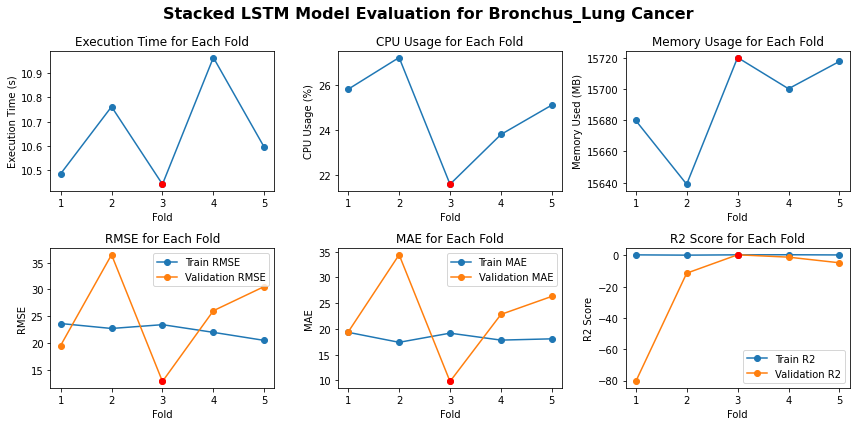

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load and preprocess the cancer dataset
data = pd.DataFrame({
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'Bladder': [23, 19, 19, 18, 29, 43, 62, 30, 29, 34, 25, 25, 22, 29, 40, 25, 41, 41, 29, 37, 13],
    'Brain': [24, 26, 28, 26, 40, 44, 68, 42, 31, 29, 35, 36, 30, 31, 31, 32, 13, 16, 24, 14, 9],
    'Breast': [68, 90, 86, 53, 91, 103, 133, 124, 114, 97, 157, 144, 143, 150, 244, 179, 219, 190, 130, 199, 133],
    'Bronchus_Lung': [37, 35, 36, 31, 74, 101, 101, 79, 89, 75, 61, 36, 63, 71, 99, 56, 15, 35, 9, 37, 39],
    'Colorectal': [22, 22, 24, 10, 36, 31, 42, 24, 37, 36, 47, 49, 53, 49, 70, 57, 24, 39, 35, 46, 21],
    'Leukemia': [20, 20, 25, 23, 33, 39, 63, 52, 48, 32, 59, 46, 53, 35, 53, 47, 33, 55, 38, 41, 46],
    'Non_Hodgkins_Lymphoma': [47, 18, 27, 18, 31, 33, 35, 18, 31, 23, 48, 39, 37, 28, 49, 31, 34, 34, 3, 22, 30],
    'Stomach': [18, 18, 21, 25, 25, 34, 34, 27, 33, 40, 20, 31, 26, 39, 37, 27, 20, 21, 11, 12, 12]
})

# Select a cancer type column as the target variable
cancer_type = 'Bronchus_Lung'  # Change to the desired cancer type

target = data[cancer_type].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Define number of folds
num_folds = 5

# Compute fold size
fold_size = len(target_scaled) // num_folds

# Initialize lists to store evaluation metrics and computation calculations for each fold
eval_metrics = []
execution_times = []
cpu_usages = []
memory_usages = []

# Initialize variables for best fold and metric
best_fold = 0
best_metric = float('inf')

# Perform k-fold cross-validation
for fold in range(1, num_folds + 1):
    # Define the training and validation data for the current fold
    start_index = (fold - 1) * fold_size
    end_index = fold * fold_size
    val_data = target_scaled[start_index:end_index]
    train_data = np.concatenate((target_scaled[:start_index], target_scaled[end_index:]))

    def train_evaluate_model(train_data, val_data):
        X_train, y_train = train_data[:-1], train_data[1:]
        X_val, y_val = val_data[:-1], val_data[1:]

        # Define and train the Stacked LSTM model
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(1, 1)))
        model.add(LSTM(64))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # Make predictions
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)

        # Invert the scaling
        train_predictions = scaler.inverse_transform(train_predictions)
        y_train = scaler.inverse_transform(y_train)
        val_predictions = scaler.inverse_transform(val_predictions)
        y_val = scaler.inverse_transform(y_val)

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        train_r2 = r2_score(y_train, train_predictions)
        val_r2 = r2_score(y_val, val_predictions)

        # Store evaluation metrics for the current fold
        eval_metrics.append((train_rmse, val_rmse, train_mae, val_mae, train_r2, val_r2))

        return train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions

    # Train and evaluate the Stacked LSTM model
    start_time = time.time()
    train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions = train_evaluate_model(train_data, val_data)
    computation_time = time.time() - start_time

    # Measure CPU usage during model training
    cpu_usage = psutil.cpu_percent()

    # Record computation calculations
    execution_times.append(computation_time)
    cpu_usages.append(cpu_usage)
    memory_usages.append(psutil.virtual_memory().used / 1024 / 1024)  # Memory usage in MB

    # Check if the current fold has the best metric
    if val_rmse < best_metric:
        best_metric = val_rmse
        best_fold = fold

    # Print computation calculations for the current fold
    print(f"\nComputation calculations for Fold {fold}:")
    print(f"Execution Time: {computation_time:.2f} seconds")
    print(f"CPU Usage: {cpu_usage}%")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024:.2f} MB")

# Print the evaluation metrics for the best fold
best_train_rmse, best_val_rmse, best_train_mae, best_val_mae, best_train_r2, best_val_r2 = eval_metrics[best_fold - 1]
print(f"\nBest Fold: {best_fold}")
print(f"Best Train RMSE: {best_train_rmse:.5f}")
print(f"Best Validation RMSE: {best_val_rmse:.5f}")
print(f"Best Train MAE: {best_train_mae:.5f}")
print(f"Best Validation MAE: {best_val_mae:.5f}")
print(f"Best Train R2: {best_train_r2:.5f}")
print(f"Best Validation R2: {best_val_r2:.5f}")

# Plot computation calculations for each fold
plt.figure(figsize=(12, 6))
plt.suptitle(f'Stacked LSTM Model Evaluation for {cancer_type} Cancer', fontsize=16, fontweight='bold')

plt.subplot(231)
plt.plot(range(1, num_folds + 1), execution_times, 'o-')
plt.plot(best_fold, execution_times[best_fold - 1], 'ro')
plt.title('Execution Time for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Execution Time (s)')

plt.subplot(232)
plt.plot(range(1, num_folds + 1), cpu_usages, 'o-')
plt.plot(best_fold, cpu_usages[best_fold - 1], 'ro')
plt.title('CPU Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('CPU Usage (%)')

plt.subplot(233)
plt.plot(range(1, num_folds + 1), memory_usages, 'o-')
plt.plot(best_fold, memory_usages[best_fold - 1], 'ro')
plt.title('Memory Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Memory Used (MB)')

# Plot evaluation metrics for each fold
plt.subplot(234)
train_rmses = [metrics[0] for metrics in eval_metrics]
val_rmses = [metrics[1] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_rmses, 'o-', label='Train RMSE')
plt.plot(range(1, num_folds + 1), val_rmses, 'o-', label='Validation RMSE')
plt.plot(best_fold, best_val_rmse, 'ro')
plt.title('RMSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(235)
train_maes = [metrics[2] for metrics in eval_metrics]
val_maes = [metrics[3] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_maes, 'o-', label='Train MAE')
plt.plot(range(1, num_folds + 1), val_maes, 'o-', label='Validation MAE')
plt.plot(best_fold, best_val_mae, 'ro')
plt.title('MAE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend()

plt.subplot(236)
train_r2_scores = [metrics[4] for metrics in eval_metrics]
val_r2_scores = [metrics[5] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_r2_scores, 'o-', label='Train R2')
plt.plot(range(1, num_folds + 1), val_r2_scores, 'o-', label='Validation R2')
plt.plot(best_fold, best_val_r2, 'ro')
plt.title('R2 Score for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 46ms/step

Computation calculations for Fold 1:
Execution Time: 10.41 seconds
CPU Usage: 13.8%
Memory Used: 15827.91 MB
1/1 [==============================] - 0s 41ms/step

Computation calculations for Fold 2:
Execution Time: 10.52 seconds
CPU Usage: 23.7%
Memory Used: 15821.32 MB
1/1 [==============================] - 0s 40ms/step

Computation calculations for Fold 3:
Execution Time: 11.12 seconds
CPU Usage: 24.8%
Memory Used: 15829.18 MB
1/1 [==============================] - 0s 40ms/step

Computation calculations for Fold 4:
Execution Time: 11.00 seconds
CPU Usage: 22.3%
Memory Used: 15824.24 MB
1/1 [==============================] - 0s 40ms/step

Computation calculations for Fold 5:
Execution Time: 11.09 seconds
CPU Usage: 28.2%
Memory Used: 15832.24 MB

Best Fold: 5
Best Train RMSE: 13.19407
Best Validation RMSE: 6.66734
Best Train MAE: 10.70830
Best Validation MAE: 6.19243
Best Train R2: 0.25286
Best Validation R2: -1.15097


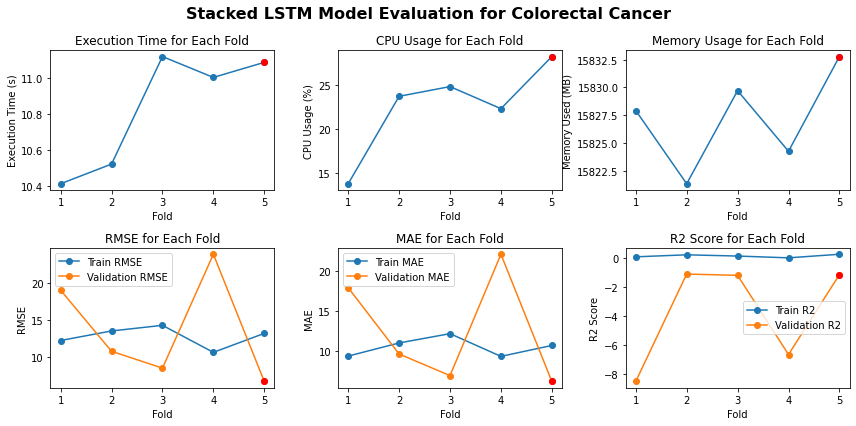

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load and preprocess the cancer dataset
data = pd.DataFrame({
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'Bladder': [23, 19, 19, 18, 29, 43, 62, 30, 29, 34, 25, 25, 22, 29, 40, 25, 41, 41, 29, 37, 13],
    'Brain': [24, 26, 28, 26, 40, 44, 68, 42, 31, 29, 35, 36, 30, 31, 31, 32, 13, 16, 24, 14, 9],
    'Breast': [68, 90, 86, 53, 91, 103, 133, 124, 114, 97, 157, 144, 143, 150, 244, 179, 219, 190, 130, 199, 133],
    'Bronchus_Lung': [37, 35, 36, 31, 74, 101, 101, 79, 89, 75, 61, 36, 63, 71, 99, 56, 15, 35, 9, 37, 39],
    'Colorectal': [22, 22, 24, 10, 36, 31, 42, 24, 37, 36, 47, 49, 53, 49, 70, 57, 24, 39, 35, 46, 21],
    'Leukemia': [20, 20, 25, 23, 33, 39, 63, 52, 48, 32, 59, 46, 53, 35, 53, 47, 33, 55, 38, 41, 46],
    'Non_Hodgkins_Lymphoma': [47, 18, 27, 18, 31, 33, 35, 18, 31, 23, 48, 39, 37, 28, 49, 31, 34, 34, 3, 22, 30],
    'Stomach': [18, 18, 21, 25, 25, 34, 34, 27, 33, 40, 20, 31, 26, 39, 37, 27, 20, 21, 11, 12, 12]
})

# Select a cancer type column as the target variable
cancer_type = 'Colorectal'  # Change to the desired cancer type

target = data[cancer_type].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Define number of folds
num_folds = 5

# Compute fold size
fold_size = len(target_scaled) // num_folds

# Initialize lists to store evaluation metrics and computation calculations for each fold
eval_metrics = []
execution_times = []
cpu_usages = []
memory_usages = []

# Initialize variables for best fold and metric
best_fold = 0
best_metric = float('inf')

# Perform k-fold cross-validation
for fold in range(1, num_folds + 1):
    # Define the training and validation data for the current fold
    start_index = (fold - 1) * fold_size
    end_index = fold * fold_size
    val_data = target_scaled[start_index:end_index]
    train_data = np.concatenate((target_scaled[:start_index], target_scaled[end_index:]))

    def train_evaluate_model(train_data, val_data):
        X_train, y_train = train_data[:-1], train_data[1:]
        X_val, y_val = val_data[:-1], val_data[1:]

        # Define and train the Stacked LSTM model
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(1, 1)))
        model.add(LSTM(64))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # Make predictions
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)

        # Invert the scaling
        train_predictions = scaler.inverse_transform(train_predictions)
        y_train = scaler.inverse_transform(y_train)
        val_predictions = scaler.inverse_transform(val_predictions)
        y_val = scaler.inverse_transform(y_val)

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        train_r2 = r2_score(y_train, train_predictions)
        val_r2 = r2_score(y_val, val_predictions)

        # Store evaluation metrics for the current fold
        eval_metrics.append((train_rmse, val_rmse, train_mae, val_mae, train_r2, val_r2))

        return train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions

    # Train and evaluate the Stacked LSTM model
    start_time = time.time()
    train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions = train_evaluate_model(train_data, val_data)
    computation_time = time.time() - start_time

    # Measure CPU usage during model training
    cpu_usage = psutil.cpu_percent()

    # Record computation calculations
    execution_times.append(computation_time)
    cpu_usages.append(cpu_usage)
    memory_usages.append(psutil.virtual_memory().used / 1024 / 1024)  # Memory usage in MB

    # Check if the current fold has the best metric
    if val_rmse < best_metric:
        best_metric = val_rmse
        best_fold = fold

    # Print computation calculations for the current fold
    print(f"\nComputation calculations for Fold {fold}:")
    print(f"Execution Time: {computation_time:.2f} seconds")
    print(f"CPU Usage: {cpu_usage}%")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024:.2f} MB")

# Print the evaluation metrics for the best fold
best_train_rmse, best_val_rmse, best_train_mae, best_val_mae, best_train_r2, best_val_r2 = eval_metrics[best_fold - 1]
print(f"\nBest Fold: {best_fold}")
print(f"Best Train RMSE: {best_train_rmse:.5f}")
print(f"Best Validation RMSE: {best_val_rmse:.5f}")
print(f"Best Train MAE: {best_train_mae:.5f}")
print(f"Best Validation MAE: {best_val_mae:.5f}")
print(f"Best Train R2: {best_train_r2:.5f}")
print(f"Best Validation R2: {best_val_r2:.5f}")

# Plot computation calculations for each fold
plt.figure(figsize=(12, 6))
plt.suptitle(f'Stacked LSTM Model Evaluation for {cancer_type} Cancer', fontsize=16, fontweight='bold')

plt.subplot(231)
plt.plot(range(1, num_folds + 1), execution_times, 'o-')
plt.plot(best_fold, execution_times[best_fold - 1], 'ro')
plt.title('Execution Time for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Execution Time (s)')

plt.subplot(232)
plt.plot(range(1, num_folds + 1), cpu_usages, 'o-')
plt.plot(best_fold, cpu_usages[best_fold - 1], 'ro')
plt.title('CPU Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('CPU Usage (%)')

plt.subplot(233)
plt.plot(range(1, num_folds + 1), memory_usages, 'o-')
plt.plot(best_fold, memory_usages[best_fold - 1], 'ro')
plt.title('Memory Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Memory Used (MB)')

# Plot evaluation metrics for each fold
plt.subplot(234)
train_rmses = [metrics[0] for metrics in eval_metrics]
val_rmses = [metrics[1] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_rmses, 'o-', label='Train RMSE')
plt.plot(range(1, num_folds + 1), val_rmses, 'o-', label='Validation RMSE')
plt.plot(best_fold, best_val_rmse, 'ro')
plt.title('RMSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(235)
train_maes = [metrics[2] for metrics in eval_metrics]
val_maes = [metrics[3] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_maes, 'o-', label='Train MAE')
plt.plot(range(1, num_folds + 1), val_maes, 'o-', label='Validation MAE')
plt.plot(best_fold, best_val_mae, 'ro')
plt.title('MAE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend()

plt.subplot(236)
train_r2_scores = [metrics[4] for metrics in eval_metrics]
val_r2_scores = [metrics[5] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_r2_scores, 'o-', label='Train R2')
plt.plot(range(1, num_folds + 1), val_r2_scores, 'o-', label='Validation R2')
plt.plot(best_fold, best_val_r2, 'ro')
plt.title('R2 Score for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 41ms/step

Computation calculations for Fold 1:
Execution Time: 10.73 seconds
CPU Usage: 18.5%
Memory Used: 15883.62 MB
1/1 [==============================] - 0s 41ms/step

Computation calculations for Fold 2:
Execution Time: 10.08 seconds
CPU Usage: 24.2%
Memory Used: 15908.18 MB
1/1 [==============================] - 0s 43ms/step

Computation calculations for Fold 3:
Execution Time: 10.73 seconds
CPU Usage: 29.6%
Memory Used: 15947.61 MB
1/1 [==============================] - 0s 40ms/step

Computation calculations for Fold 4:
Execution Time: 10.35 seconds
CPU Usage: 24.8%
Memory Used: 15944.35 MB
1/1 [==============================] - 0s 39ms/step

Computation calculations for Fold 5:
Execution Time: 10.81 seconds
CPU Usage: 20.8%
Memory Used: 15862.76 MB

Best Fold: 4
Best Train RMSE: 10.82783
Best Validation RMSE: 9.96660
Best Train MAE: 8.35599
Best Validation MAE: 8.40715
Best Train R2: 0.23944
Best Validation R2: -0.77381


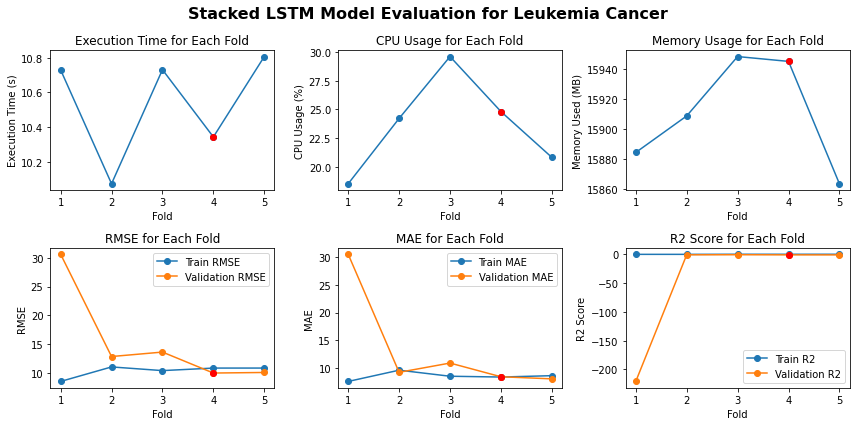

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load and preprocess the cancer dataset
data = pd.DataFrame({
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'Bladder': [23, 19, 19, 18, 29, 43, 62, 30, 29, 34, 25, 25, 22, 29, 40, 25, 41, 41, 29, 37, 13],
    'Brain': [24, 26, 28, 26, 40, 44, 68, 42, 31, 29, 35, 36, 30, 31, 31, 32, 13, 16, 24, 14, 9],
    'Breast': [68, 90, 86, 53, 91, 103, 133, 124, 114, 97, 157, 144, 143, 150, 244, 179, 219, 190, 130, 199, 133],
    'Bronchus_Lung': [37, 35, 36, 31, 74, 101, 101, 79, 89, 75, 61, 36, 63, 71, 99, 56, 15, 35, 9, 37, 39],
    'Colorectal': [22, 22, 24, 10, 36, 31, 42, 24, 37, 36, 47, 49, 53, 49, 70, 57, 24, 39, 35, 46, 21],
    'Leukemia': [20, 20, 25, 23, 33, 39, 63, 52, 48, 32, 59, 46, 53, 35, 53, 47, 33, 55, 38, 41, 46],
    'Non_Hodgkins_Lymphoma': [47, 18, 27, 18, 31, 33, 35, 18, 31, 23, 48, 39, 37, 28, 49, 31, 34, 34, 3, 22, 30],
    'Stomach': [18, 18, 21, 25, 25, 34, 34, 27, 33, 40, 20, 31, 26, 39, 37, 27, 20, 21, 11, 12, 12]
})

# Select a cancer type column as the target variable
cancer_type = 'Leukemia'  # Change to the desired cancer type

target = data[cancer_type].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Define number of folds
num_folds = 5

# Compute fold size
fold_size = len(target_scaled) // num_folds

# Initialize lists to store evaluation metrics and computation calculations for each fold
eval_metrics = []
execution_times = []
cpu_usages = []
memory_usages = []

# Initialize variables for best fold and metric
best_fold = 0
best_metric = float('inf')

# Perform k-fold cross-validation
for fold in range(1, num_folds + 1):
    # Define the training and validation data for the current fold
    start_index = (fold - 1) * fold_size
    end_index = fold * fold_size
    val_data = target_scaled[start_index:end_index]
    train_data = np.concatenate((target_scaled[:start_index], target_scaled[end_index:]))

    def train_evaluate_model(train_data, val_data):
        X_train, y_train = train_data[:-1], train_data[1:]
        X_val, y_val = val_data[:-1], val_data[1:]

        # Define and train the Stacked LSTM model
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(1, 1)))
        model.add(LSTM(64))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # Make predictions
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)

        # Invert the scaling
        train_predictions = scaler.inverse_transform(train_predictions)
        y_train = scaler.inverse_transform(y_train)
        val_predictions = scaler.inverse_transform(val_predictions)
        y_val = scaler.inverse_transform(y_val)

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        train_r2 = r2_score(y_train, train_predictions)
        val_r2 = r2_score(y_val, val_predictions)

        # Store evaluation metrics for the current fold
        eval_metrics.append((train_rmse, val_rmse, train_mae, val_mae, train_r2, val_r2))

        return train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions

    # Train and evaluate the Stacked LSTM model
    start_time = time.time()
    train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions = train_evaluate_model(train_data, val_data)
    computation_time = time.time() - start_time

    # Measure CPU usage during model training
    cpu_usage = psutil.cpu_percent()

    # Record computation calculations
    execution_times.append(computation_time)
    cpu_usages.append(cpu_usage)
    memory_usages.append(psutil.virtual_memory().used / 1024 / 1024)  # Memory usage in MB

    # Check if the current fold has the best metric
    if val_rmse < best_metric:
        best_metric = val_rmse
        best_fold = fold

    # Print computation calculations for the current fold
    print(f"\nComputation calculations for Fold {fold}:")
    print(f"Execution Time: {computation_time:.2f} seconds")
    print(f"CPU Usage: {cpu_usage}%")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024:.2f} MB")

# Print the evaluation metrics for the best fold
best_train_rmse, best_val_rmse, best_train_mae, best_val_mae, best_train_r2, best_val_r2 = eval_metrics[best_fold - 1]
print(f"\nBest Fold: {best_fold}")
print(f"Best Train RMSE: {best_train_rmse:.5f}")
print(f"Best Validation RMSE: {best_val_rmse:.5f}")
print(f"Best Train MAE: {best_train_mae:.5f}")
print(f"Best Validation MAE: {best_val_mae:.5f}")
print(f"Best Train R2: {best_train_r2:.5f}")
print(f"Best Validation R2: {best_val_r2:.5f}")

# Plot computation calculations for each fold
plt.figure(figsize=(12, 6))
plt.suptitle(f'Stacked LSTM Model Evaluation for {cancer_type} Cancer', fontsize=16, fontweight='bold')

plt.subplot(231)
plt.plot(range(1, num_folds + 1), execution_times, 'o-')
plt.plot(best_fold, execution_times[best_fold - 1], 'ro')
plt.title('Execution Time for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Execution Time (s)')

plt.subplot(232)
plt.plot(range(1, num_folds + 1), cpu_usages, 'o-')
plt.plot(best_fold, cpu_usages[best_fold - 1], 'ro')
plt.title('CPU Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('CPU Usage (%)')

plt.subplot(233)
plt.plot(range(1, num_folds + 1), memory_usages, 'o-')
plt.plot(best_fold, memory_usages[best_fold - 1], 'ro')
plt.title('Memory Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Memory Used (MB)')

# Plot evaluation metrics for each fold
plt.subplot(234)
train_rmses = [metrics[0] for metrics in eval_metrics]
val_rmses = [metrics[1] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_rmses, 'o-', label='Train RMSE')
plt.plot(range(1, num_folds + 1), val_rmses, 'o-', label='Validation RMSE')
plt.plot(best_fold, best_val_rmse, 'ro')
plt.title('RMSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(235)
train_maes = [metrics[2] for metrics in eval_metrics]
val_maes = [metrics[3] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_maes, 'o-', label='Train MAE')
plt.plot(range(1, num_folds + 1), val_maes, 'o-', label='Validation MAE')
plt.plot(best_fold, best_val_mae, 'ro')
plt.title('MAE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend()

plt.subplot(236)
train_r2_scores = [metrics[4] for metrics in eval_metrics]
val_r2_scores = [metrics[5] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_r2_scores, 'o-', label='Train R2')
plt.plot(range(1, num_folds + 1), val_r2_scores, 'o-', label='Validation R2')
plt.plot(best_fold, best_val_r2, 'ro')
plt.title('R2 Score for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 47ms/step

Computation calculations for Fold 1:
Execution Time: 10.36 seconds
CPU Usage: 23.6%
Memory Used: 15861.36 MB
1/1 [==============================] - 0s 37ms/step

Computation calculations for Fold 2:
Execution Time: 10.70 seconds
CPU Usage: 31.4%
Memory Used: 15874.35 MB
1/1 [==============================] - 0s 41ms/step

Computation calculations for Fold 3:
Execution Time: 10.36 seconds
CPU Usage: 30.4%
Memory Used: 15870.20 MB
1/1 [==============================] - 0s 34ms/step

Computation calculations for Fold 4:
Execution Time: 10.75 seconds
CPU Usage: 25.0%
Memory Used: 15860.12 MB
1/1 [==============================] - 0s 36ms/step

Computation calculations for Fold 5:
Execution Time: 10.28 seconds
CPU Usage: 24.1%
Memory Used: 15887.25 MB

Best Fold: 2
Best Train RMSE: 11.08507
Best Validation RMSE: 7.67718
Best Train MAE: 8.31099
Best Validation MAE: 6.68179
Best Train R2: 0.01104
Best Validation R2: -0.02404


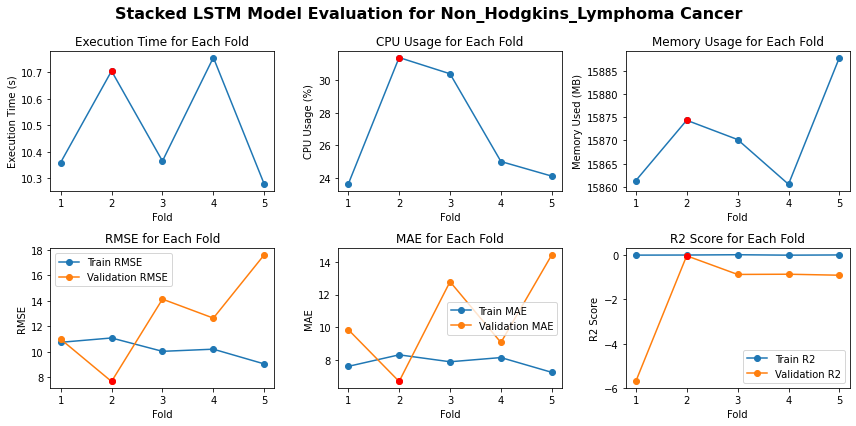

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load and preprocess the cancer dataset
data = pd.DataFrame({
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'Bladder': [23, 19, 19, 18, 29, 43, 62, 30, 29, 34, 25, 25, 22, 29, 40, 25, 41, 41, 29, 37, 13],
    'Brain': [24, 26, 28, 26, 40, 44, 68, 42, 31, 29, 35, 36, 30, 31, 31, 32, 13, 16, 24, 14, 9],
    'Breast': [68, 90, 86, 53, 91, 103, 133, 124, 114, 97, 157, 144, 143, 150, 244, 179, 219, 190, 130, 199, 133],
    'Bronchus_Lung': [37, 35, 36, 31, 74, 101, 101, 79, 89, 75, 61, 36, 63, 71, 99, 56, 15, 35, 9, 37, 39],
    'Colorectal': [22, 22, 24, 10, 36, 31, 42, 24, 37, 36, 47, 49, 53, 49, 70, 57, 24, 39, 35, 46, 21],
    'Leukemia': [20, 20, 25, 23, 33, 39, 63, 52, 48, 32, 59, 46, 53, 35, 53, 47, 33, 55, 38, 41, 46],
    'Non_Hodgkins_Lymphoma': [47, 18, 27, 18, 31, 33, 35, 18, 31, 23, 48, 39, 37, 28, 49, 31, 34, 34, 3, 22, 30],
    'Stomach': [18, 18, 21, 25, 25, 34, 34, 27, 33, 40, 20, 31, 26, 39, 37, 27, 20, 21, 11, 12, 12]
})

# Select a cancer type column as the target variable
cancer_type = 'Non_Hodgkins_Lymphoma'  # Change to the desired cancer type

target = data[cancer_type].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Define number of folds
num_folds = 5

# Compute fold size
fold_size = len(target_scaled) // num_folds

# Initialize lists to store evaluation metrics and computation calculations for each fold
eval_metrics = []
execution_times = []
cpu_usages = []
memory_usages = []

# Initialize variables for best fold and metric
best_fold = 0
best_metric = float('inf')

# Perform k-fold cross-validation
for fold in range(1, num_folds + 1):
    # Define the training and validation data for the current fold
    start_index = (fold - 1) * fold_size
    end_index = fold * fold_size
    val_data = target_scaled[start_index:end_index]
    train_data = np.concatenate((target_scaled[:start_index], target_scaled[end_index:]))

    def train_evaluate_model(train_data, val_data):
        X_train, y_train = train_data[:-1], train_data[1:]
        X_val, y_val = val_data[:-1], val_data[1:]

        # Define and train the Stacked LSTM model
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(1, 1)))
        model.add(LSTM(64))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # Make predictions
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)

        # Invert the scaling
        train_predictions = scaler.inverse_transform(train_predictions)
        y_train = scaler.inverse_transform(y_train)
        val_predictions = scaler.inverse_transform(val_predictions)
        y_val = scaler.inverse_transform(y_val)

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        train_r2 = r2_score(y_train, train_predictions)
        val_r2 = r2_score(y_val, val_predictions)

        # Store evaluation metrics for the current fold
        eval_metrics.append((train_rmse, val_rmse, train_mae, val_mae, train_r2, val_r2))

        return train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions

    # Train and evaluate the Stacked LSTM model
    start_time = time.time()
    train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions = train_evaluate_model(train_data, val_data)
    computation_time = time.time() - start_time

    # Measure CPU usage during model training
    cpu_usage = psutil.cpu_percent()

    # Record computation calculations
    execution_times.append(computation_time)
    cpu_usages.append(cpu_usage)
    memory_usages.append(psutil.virtual_memory().used / 1024 / 1024)  # Memory usage in MB

    # Check if the current fold has the best metric
    if val_rmse < best_metric:
        best_metric = val_rmse
        best_fold = fold

    # Print computation calculations for the current fold
    print(f"\nComputation calculations for Fold {fold}:")
    print(f"Execution Time: {computation_time:.2f} seconds")
    print(f"CPU Usage: {cpu_usage}%")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024:.2f} MB")

# Print the evaluation metrics for the best fold
best_train_rmse, best_val_rmse, best_train_mae, best_val_mae, best_train_r2, best_val_r2 = eval_metrics[best_fold - 1]
print(f"\nBest Fold: {best_fold}")
print(f"Best Train RMSE: {best_train_rmse:.5f}")
print(f"Best Validation RMSE: {best_val_rmse:.5f}")
print(f"Best Train MAE: {best_train_mae:.5f}")
print(f"Best Validation MAE: {best_val_mae:.5f}")
print(f"Best Train R2: {best_train_r2:.5f}")
print(f"Best Validation R2: {best_val_r2:.5f}")

# Plot computation calculations for each fold
plt.figure(figsize=(12, 6))
plt.suptitle(f'Stacked LSTM Model Evaluation for {cancer_type} Cancer', fontsize=16, fontweight='bold')

plt.subplot(231)
plt.plot(range(1, num_folds + 1), execution_times, 'o-')
plt.plot(best_fold, execution_times[best_fold - 1], 'ro')
plt.title('Execution Time for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Execution Time (s)')

plt.subplot(232)
plt.plot(range(1, num_folds + 1), cpu_usages, 'o-')
plt.plot(best_fold, cpu_usages[best_fold - 1], 'ro')
plt.title('CPU Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('CPU Usage (%)')

plt.subplot(233)
plt.plot(range(1, num_folds + 1), memory_usages, 'o-')
plt.plot(best_fold, memory_usages[best_fold - 1], 'ro')
plt.title('Memory Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Memory Used (MB)')

# Plot evaluation metrics for each fold
plt.subplot(234)
train_rmses = [metrics[0] for metrics in eval_metrics]
val_rmses = [metrics[1] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_rmses, 'o-', label='Train RMSE')
plt.plot(range(1, num_folds + 1), val_rmses, 'o-', label='Validation RMSE')
plt.plot(best_fold, best_val_rmse, 'ro')
plt.title('RMSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(235)
train_maes = [metrics[2] for metrics in eval_metrics]
val_maes = [metrics[3] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_maes, 'o-', label='Train MAE')
plt.plot(range(1, num_folds + 1), val_maes, 'o-', label='Validation MAE')
plt.plot(best_fold, best_val_mae, 'ro')
plt.title('MAE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend()

plt.subplot(236)
train_r2_scores = [metrics[4] for metrics in eval_metrics]
val_r2_scores = [metrics[5] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_r2_scores, 'o-', label='Train R2')
plt.plot(range(1, num_folds + 1), val_r2_scores, 'o-', label='Validation R2')
plt.plot(best_fold, best_val_r2, 'ro')
plt.title('R2 Score for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 43ms/step

Computation calculations for Fold 1:
Execution Time: 10.98 seconds
CPU Usage: 24.1%
Memory Used: 15899.80 MB
1/1 [==============================] - 0s 49ms/step

Computation calculations for Fold 2:
Execution Time: 10.31 seconds
CPU Usage: 25.0%
Memory Used: 15900.97 MB
1/1 [==============================] - 0s 43ms/step

Computation calculations for Fold 3:
Execution Time: 10.94 seconds
CPU Usage: 24.7%
Memory Used: 15899.66 MB
1/1 [==============================] - 0s 43ms/step

Computation calculations for Fold 4:
Execution Time: 10.34 seconds
CPU Usage: 24.1%
Memory Used: 15901.73 MB
1/1 [==============================] - 0s 32ms/step

Computation calculations for Fold 5:
Execution Time: 11.50 seconds
CPU Usage: 31.0%
Memory Used: 15969.92 MB

Best Fold: 1
Best Train RMSE: 8.11295
Best Validation RMSE: 3.77375
Best Train MAE: 7.28871
Best Validation MAE: 2.94062
Best Train R2: 0.24777
Best Validation R2: -0.73203


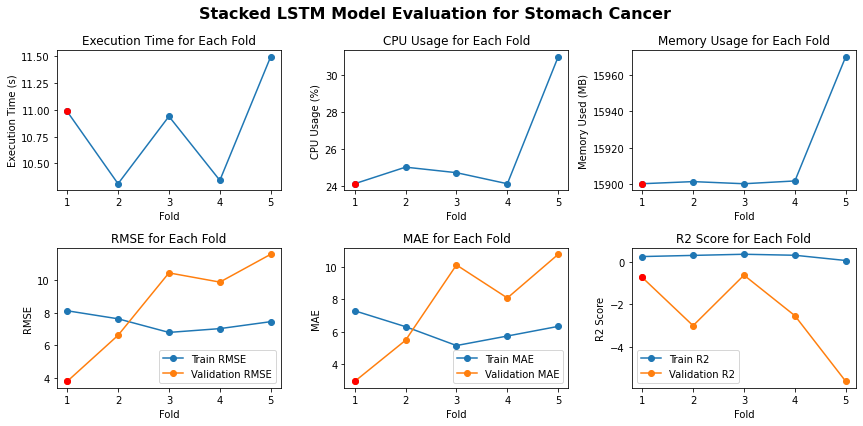

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load and preprocess the cancer dataset
data = pd.DataFrame({
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'Bladder': [23, 19, 19, 18, 29, 43, 62, 30, 29, 34, 25, 25, 22, 29, 40, 25, 41, 41, 29, 37, 13],
    'Brain': [24, 26, 28, 26, 40, 44, 68, 42, 31, 29, 35, 36, 30, 31, 31, 32, 13, 16, 24, 14, 9],
    'Breast': [68, 90, 86, 53, 91, 103, 133, 124, 114, 97, 157, 144, 143, 150, 244, 179, 219, 190, 130, 199, 133],
    'Bronchus_Lung': [37, 35, 36, 31, 74, 101, 101, 79, 89, 75, 61, 36, 63, 71, 99, 56, 15, 35, 9, 37, 39],
    'Colorectal': [22, 22, 24, 10, 36, 31, 42, 24, 37, 36, 47, 49, 53, 49, 70, 57, 24, 39, 35, 46, 21],
    'Leukemia': [20, 20, 25, 23, 33, 39, 63, 52, 48, 32, 59, 46, 53, 35, 53, 47, 33, 55, 38, 41, 46],
    'Non_Hodgkins_Lymphoma': [47, 18, 27, 18, 31, 33, 35, 18, 31, 23, 48, 39, 37, 28, 49, 31, 34, 34, 3, 22, 30],
    'Stomach': [18, 18, 21, 25, 25, 34, 34, 27, 33, 40, 20, 31, 26, 39, 37, 27, 20, 21, 11, 12, 12]
})

# Select a cancer type column as the target variable
cancer_type = 'Stomach'  # Change to the desired cancer type

target = data[cancer_type].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Define number of folds
num_folds = 5

# Compute fold size
fold_size = len(target_scaled) // num_folds

# Initialize lists to store evaluation metrics and computation calculations for each fold
eval_metrics = []
execution_times = []
cpu_usages = []
memory_usages = []

# Initialize variables for best fold and metric
best_fold = 0
best_metric = float('inf')

# Perform k-fold cross-validation
for fold in range(1, num_folds + 1):
    # Define the training and validation data for the current fold
    start_index = (fold - 1) * fold_size
    end_index = fold * fold_size
    val_data = target_scaled[start_index:end_index]
    train_data = np.concatenate((target_scaled[:start_index], target_scaled[end_index:]))

    def train_evaluate_model(train_data, val_data):
        X_train, y_train = train_data[:-1], train_data[1:]
        X_val, y_val = val_data[:-1], val_data[1:]

        # Define and train the Stacked LSTM model
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(1, 1)))
        model.add(LSTM(64))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # Make predictions
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)

        # Invert the scaling
        train_predictions = scaler.inverse_transform(train_predictions)
        y_train = scaler.inverse_transform(y_train)
        val_predictions = scaler.inverse_transform(val_predictions)
        y_val = scaler.inverse_transform(y_val)

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        train_r2 = r2_score(y_train, train_predictions)
        val_r2 = r2_score(y_val, val_predictions)

        # Store evaluation metrics for the current fold
        eval_metrics.append((train_rmse, val_rmse, train_mae, val_mae, train_r2, val_r2))

        return train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions

    # Train and evaluate the Stacked LSTM model
    start_time = time.time()
    train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions = train_evaluate_model(train_data, val_data)
    computation_time = time.time() - start_time

    # Measure CPU usage during model training
    cpu_usage = psutil.cpu_percent()

    # Record computation calculations
    execution_times.append(computation_time)
    cpu_usages.append(cpu_usage)
    memory_usages.append(psutil.virtual_memory().used / 1024 / 1024)  # Memory usage in MB

    # Check if the current fold has the best metric
    if val_rmse < best_metric:
        best_metric = val_rmse
        best_fold = fold

    # Print computation calculations for the current fold
    print(f"\nComputation calculations for Fold {fold}:")
    print(f"Execution Time: {computation_time:.2f} seconds")
    print(f"CPU Usage: {cpu_usage}%")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024:.2f} MB")

# Print the evaluation metrics for the best fold
best_train_rmse, best_val_rmse, best_train_mae, best_val_mae, best_train_r2, best_val_r2 = eval_metrics[best_fold - 1]
print(f"\nBest Fold: {best_fold}")
print(f"Best Train RMSE: {best_train_rmse:.5f}")
print(f"Best Validation RMSE: {best_val_rmse:.5f}")
print(f"Best Train MAE: {best_train_mae:.5f}")
print(f"Best Validation MAE: {best_val_mae:.5f}")
print(f"Best Train R2: {best_train_r2:.5f}")
print(f"Best Validation R2: {best_val_r2:.5f}")

# Plot computation calculations for each fold
plt.figure(figsize=(12, 6))
plt.suptitle(f'Stacked LSTM Model Evaluation for {cancer_type} Cancer', fontsize=16, fontweight='bold')

plt.subplot(231)
plt.plot(range(1, num_folds + 1), execution_times, 'o-')
plt.plot(best_fold, execution_times[best_fold - 1], 'ro')
plt.title('Execution Time for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Execution Time (s)')

plt.subplot(232)
plt.plot(range(1, num_folds + 1), cpu_usages, 'o-')
plt.plot(best_fold, cpu_usages[best_fold - 1], 'ro')
plt.title('CPU Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('CPU Usage (%)')

plt.subplot(233)
plt.plot(range(1, num_folds + 1), memory_usages, 'o-')
plt.plot(best_fold, memory_usages[best_fold - 1], 'ro')
plt.title('Memory Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Memory Used (MB)')

# Plot evaluation metrics for each fold
plt.subplot(234)
train_rmses = [metrics[0] for metrics in eval_metrics]
val_rmses = [metrics[1] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_rmses, 'o-', label='Train RMSE')
plt.plot(range(1, num_folds + 1), val_rmses, 'o-', label='Validation RMSE')
plt.plot(best_fold, best_val_rmse, 'ro')
plt.title('RMSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(235)
train_maes = [metrics[2] for metrics in eval_metrics]
val_maes = [metrics[3] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_maes, 'o-', label='Train MAE')
plt.plot(range(1, num_folds + 1), val_maes, 'o-', label='Validation MAE')
plt.plot(best_fold, best_val_mae, 'ro')
plt.title('MAE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend()

plt.subplot(236)
train_r2_scores = [metrics[4] for metrics in eval_metrics]
val_r2_scores = [metrics[5] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_r2_scores, 'o-', label='Train R2')
plt.plot(range(1, num_folds + 1), val_r2_scores, 'o-', label='Validation R2')
plt.plot(best_fold, best_val_r2, 'ro')
plt.title('R2 Score for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()
